In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (8, 5)
np.random.seed(42)

In [2]:
data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = data.frame.copy()

print(" Loaded dataset Shape:", df.shape)

 Loaded dataset Shape: (1000, 21)


In [3]:
# target mapping and split.
target_col = 'class'
df[target_col] = df[target_col].map({'good': 0, 'bad': 1}).astype(int)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numerical vs categorical features heuristically
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)


Numerical columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 20) Test shape: (200, 20)


In [5]:
# Preprocessing pipelines
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='drop'
)

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', xgb_clf)
])


In [6]:
#hyperparameter search(RandomizedSearchCV)
param_dist = {
    'clf__n_estimators': [50, 100, 150, 250],
    'clf__max_depth': [3, 4, 5, 6],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 0.2],
    'clf__reg_alpha': [0, 0.01, 0.1],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=4,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)
best_model = search.best_estimator_


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best params: {'clf__subsample': 0.8, 'clf__reg_alpha': 0.01, 'clf__n_estimators': 100, 'clf__max_depth': 4, 'clf__learning_rate': 0.05, 'clf__gamma': 0.1, 'clf__colsample_bytree': 0.6}
Best CV AUC: 0.8003571428571428


In [7]:
# Predict probabilities and labels
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test AUC: {:.4f}".format(auc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1: {:.4f}".format(f1))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Test AUC: 0.7877
Precision: 0.6667
Recall: 0.4333
F1: 0.5253

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84       140
           1       0.67      0.43      0.53        60

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [8]:
# We need the feature names after OneHotEncoder expansion
ohe = best_model.named_steps['preproc'].named_transformers_['cat']
if hasattr(ohe, 'get_feature_names_out'):
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
else:
    ohe_names = ohe.get_feature_names(cat_cols).tolist()

feature_names = num_cols + list(ohe_names)
print("Number of features after preprocessing:", len(feature_names))


Number of features after preprocessing: 61


In [9]:
# Extract the trained XGBoost model from pipeline
trained_xgb = best_model.named_steps['clf']

X_train_transformed = best_model.named_steps['preproc'].transform(X_train)
X_test_transformed = best_model.named_steps['preproc'].transform(X_test)

explainer = shap.TreeExplainer(trained_xgb, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test_transformed)
print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (200, 61)


                                          feature  mean_abs_shap
0                     checking_status_no checking       0.448512
1                                        duration       0.334150
2                                   credit_amount       0.215869
3   credit_history_critical/other existing credit       0.199633
4                              checking_status_<0       0.171177
5                             savings_status_<100       0.153474
6                          installment_commitment       0.108793
7                                   employment_<1       0.102489
8                        other_payment_plans_none       0.081940
9                        other_payment_plans_bank       0.079814
10                               purpose_used car       0.077811
11                                            age       0.076482
12                               purpose_radio/tv       0.072744
13                 property_magnitude_real estate       0.071485
14                savings

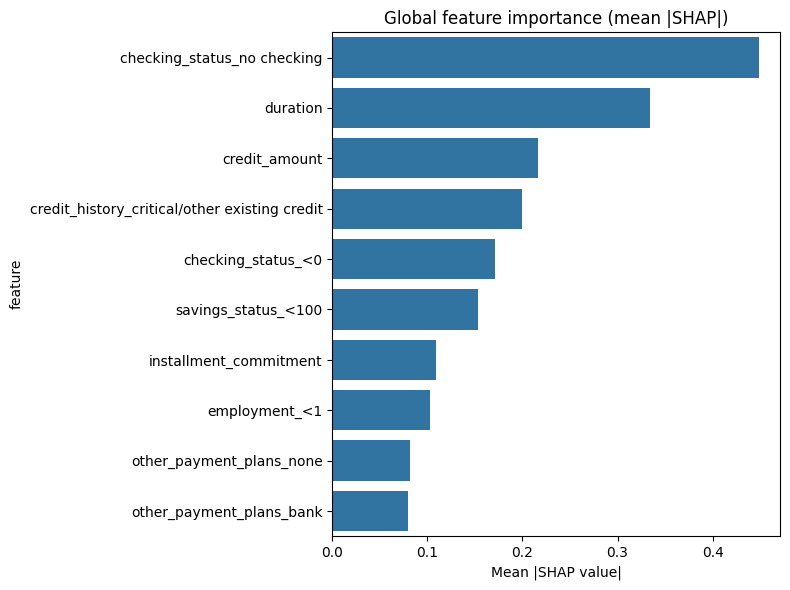

In [10]:
# Compute mean absolute shap for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

# Top 15 features
print(feat_imp.head(15))

# Bar plot - top 10
top_k = 10
plt.figure(figsize=(8,6))
sns.barplot(x='mean_abs_shap', y='feature', data=feat_imp.head(top_k))
plt.title('Global feature importance (mean |SHAP|)')
plt.xlabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()


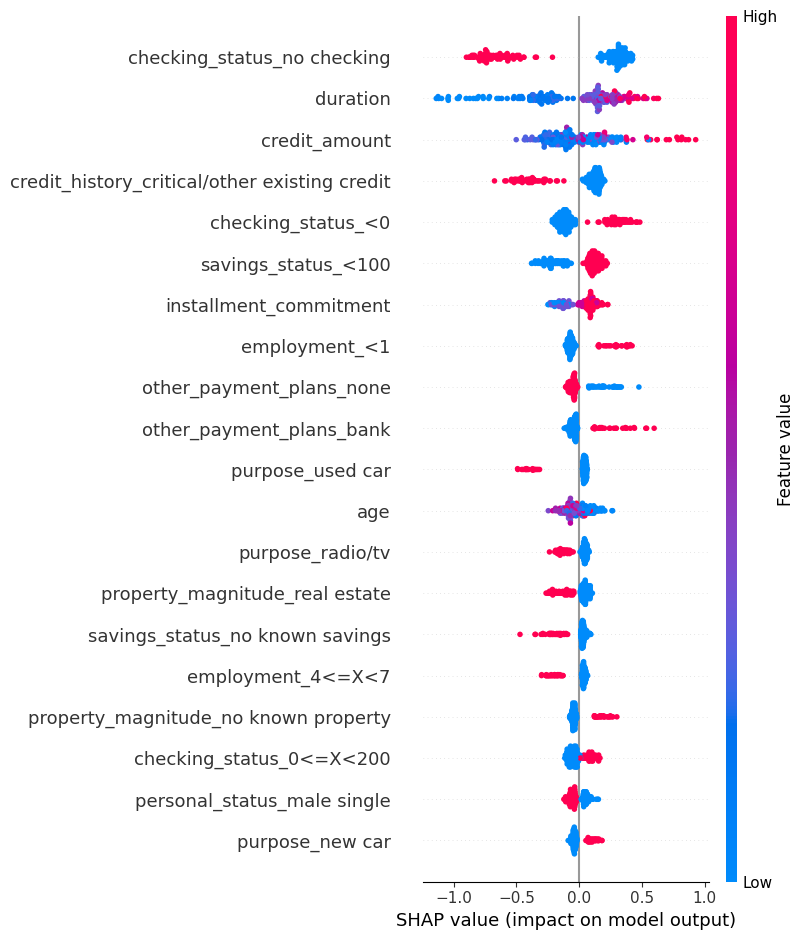

In [11]:
# Use shap.summary_plot (dot summary)
# shap expects the raw matrix and feature names
shap.initjs()
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, max_display=20, plot_type='dot')


In [12]:
# Create a dataframe of test set with predictions and probabilities
test_df = X_test.reset_index(drop=True).copy()
test_df_trans = pd.DataFrame(X_test_transformed, columns=feature_names).reset_index(drop=True)
test_df['true'] = y_test.reset_index(drop=True)
test_df['prob'] = y_proba
test_df['pred'] = y_pred
test_df['distance_to_0_5']=np.abs(test_df['prob']-0.5)

# High-risk: predicted prob >= 0.8
high_pool = test_df[test_df['prob'] >= 0.8]
# Low-risk: prob <= 0.2
low_pool = test_df[test_df['prob'] <= 0.2]
# Borderline: closest to 0.5
test_df['distance_to_0_5'] = np.abs(test_df['prob'] - 0.5)
borderline = test_df.sort_values('distance_to_0_5').head(1)

high_case = high_pool.head(1)
low_case = low_pool.head(1)

print("High case index (in test):", high_case.index.tolist())
print("Low case index (in test):", low_case.index.tolist())
print("Borderline index (in test):", borderline.index.tolist())

selected_idx = []
if len(high_case) > 0:
    selected_idx.append(high_case.index[0])
if len(low_case) > 0:
    selected_idx.append(low_case.index[0])
selected_idx.append(borderline.index[0])

selected_idx


High case index (in test): [37]
Low case index (in test): [1]
Borderline index (in test): [145]


[np.int64(37), np.int64(1), np.int64(145)]


=== Instance index (in test set): 37 ===

True label: 1 Predicted prob: 0.8417144


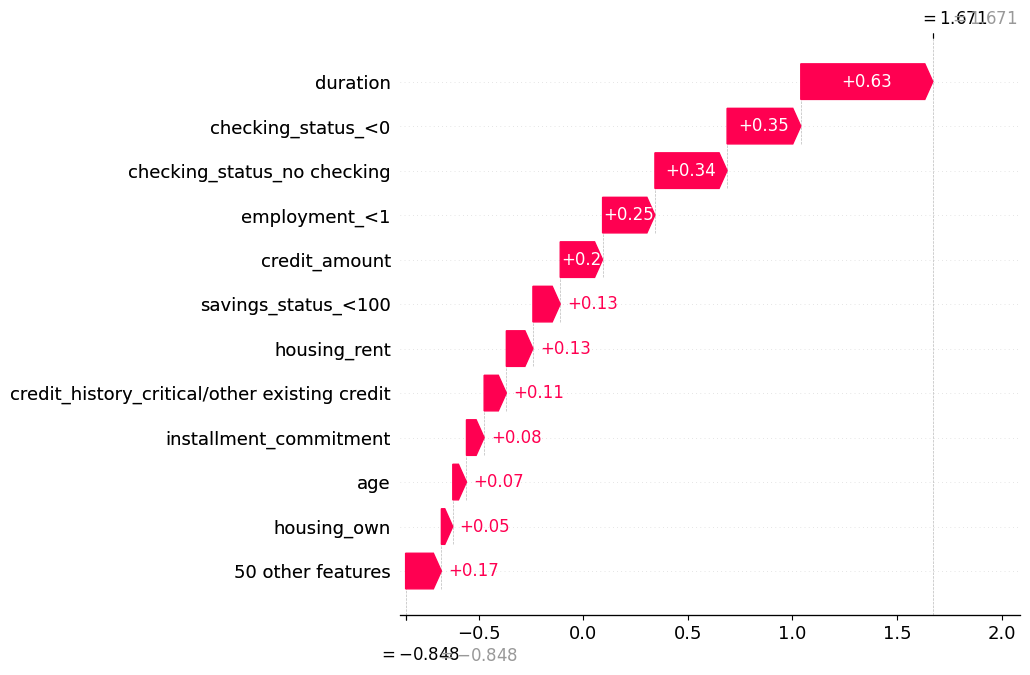

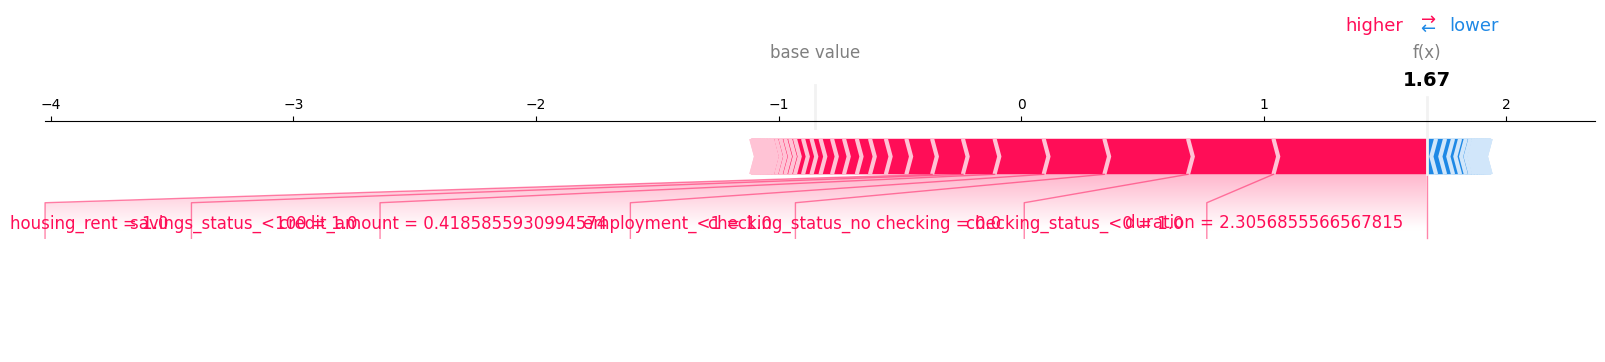


=== Instance index (in test set): 1 ===

True label: 0 Predicted prob: 0.13188328


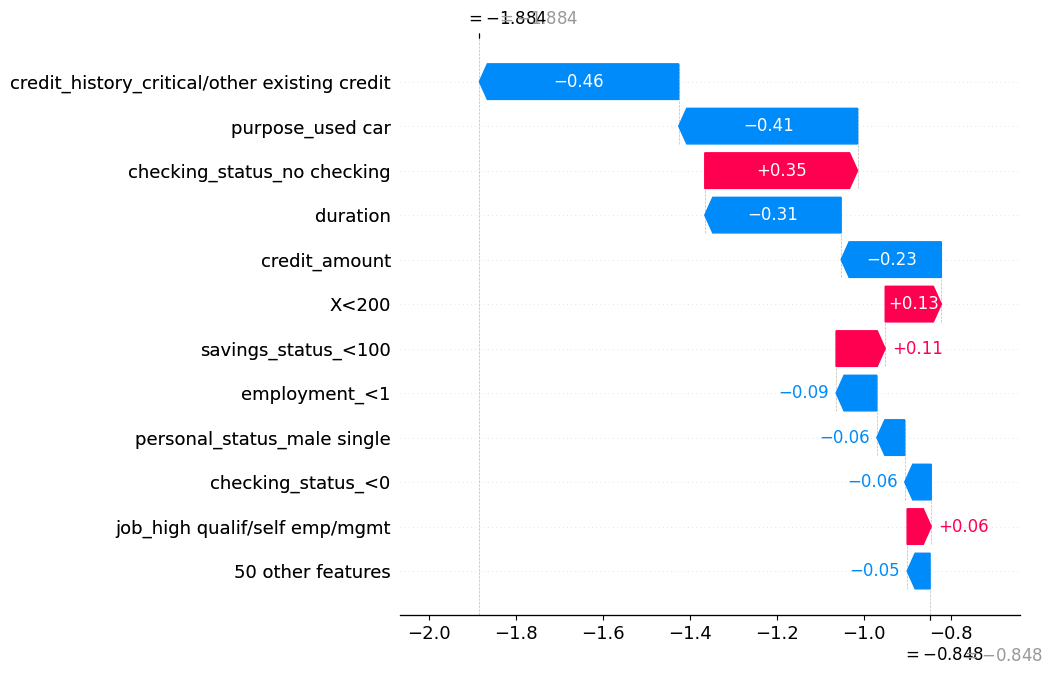

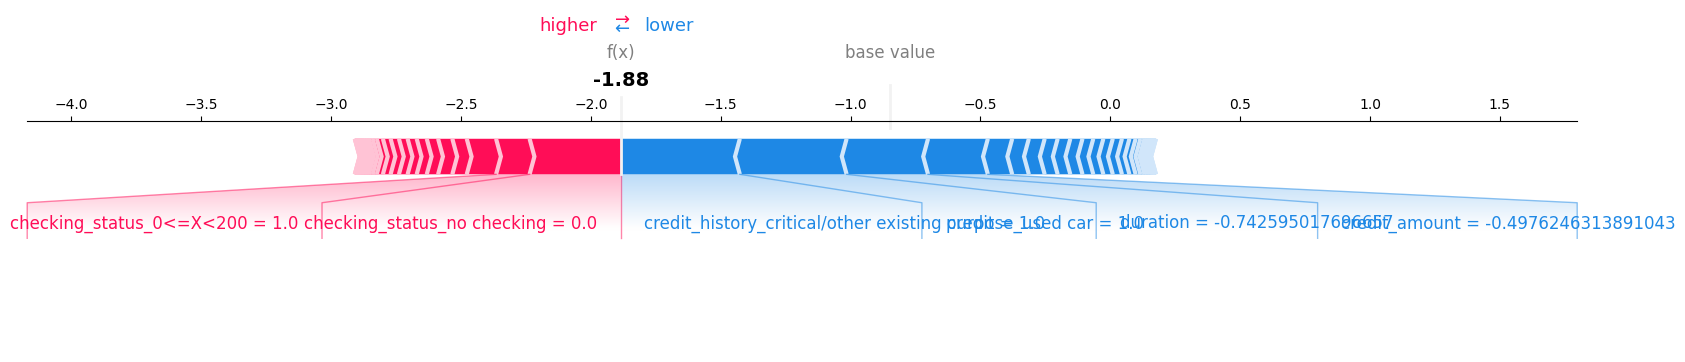


=== Instance index (in test set): 145 ===

True label: 1 Predicted prob: 0.49457574


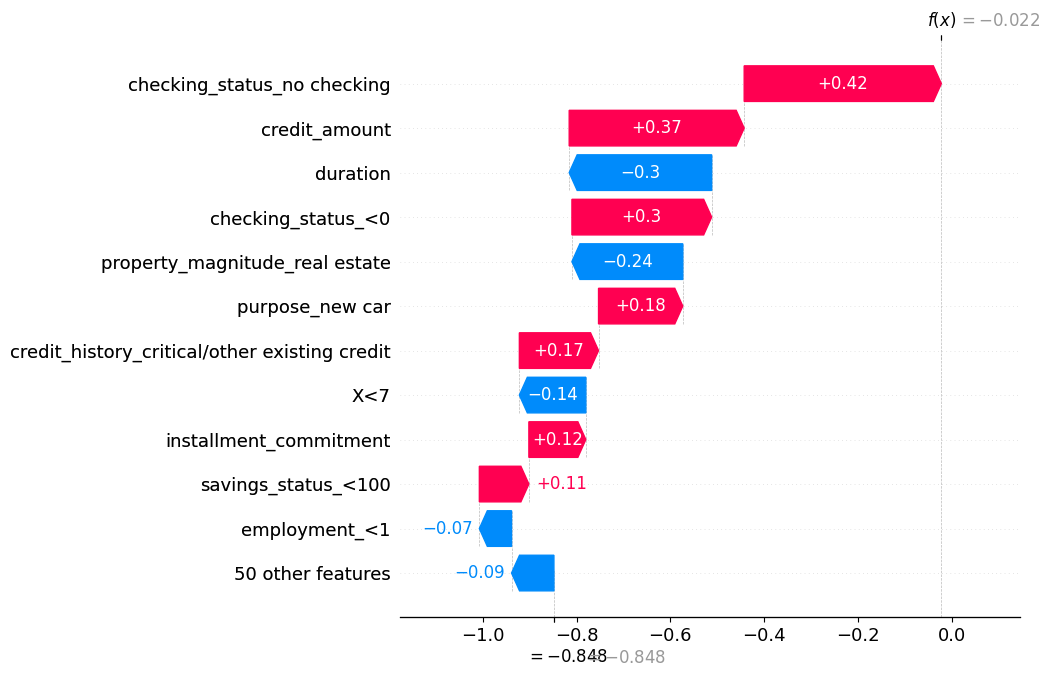

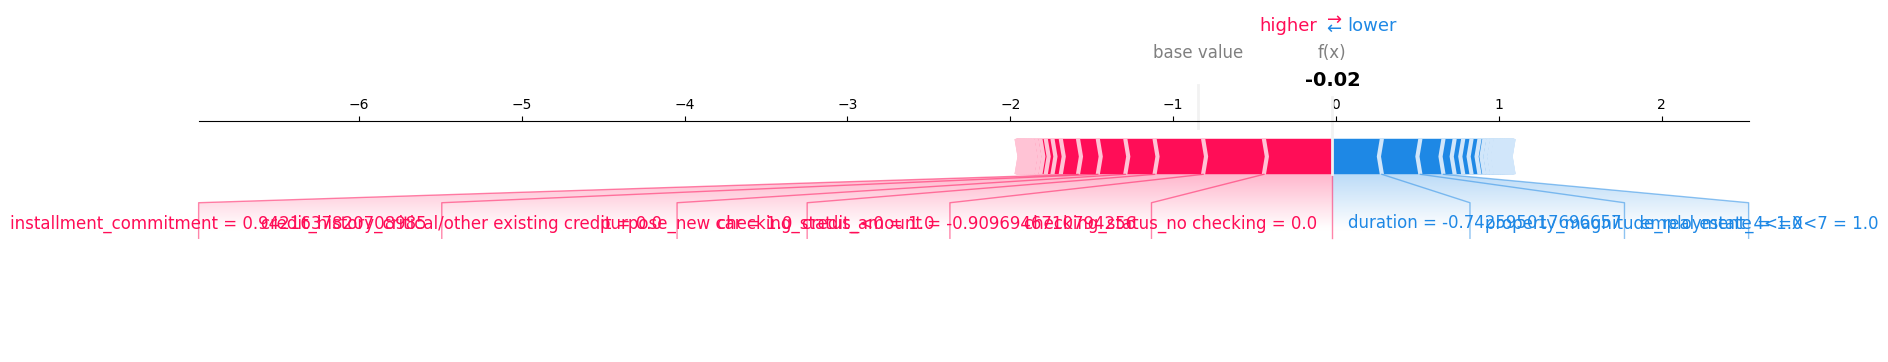

In [13]:
# Visual explanations for selected instances
for idx in selected_idx:
    print("\n=== Instance index (in test set):", idx, "===\n")
    sv = shap_values[idx]
    # display probability and true label
    print("True label:", test_df.loc[idx, 'true'], "Predicted prob:", test_df.loc[idx, 'prob'])
    # Waterfall plot (detailed)
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, sv, feature_names=feature_names, max_display=12)
    # Force plot (interactive)
    shap.force_plot(explainer.expected_value, sv, test_df_trans.loc[idx], feature_names=feature_names, matplotlib=True)
    plt.show()


Top 2 features for dependence: ['checking_status_no checking', 'duration']


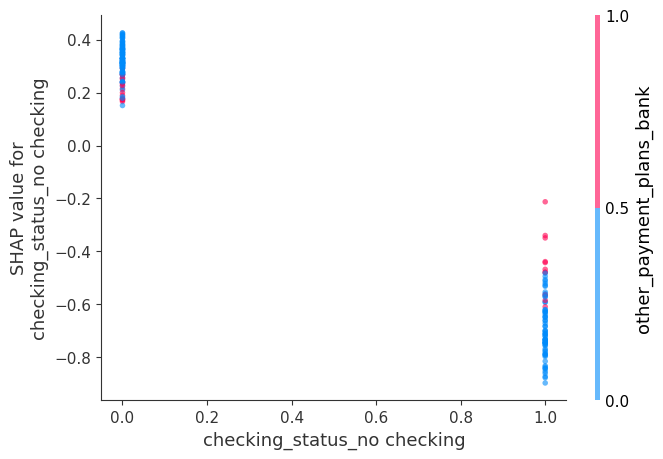

<Figure size 800x500 with 0 Axes>

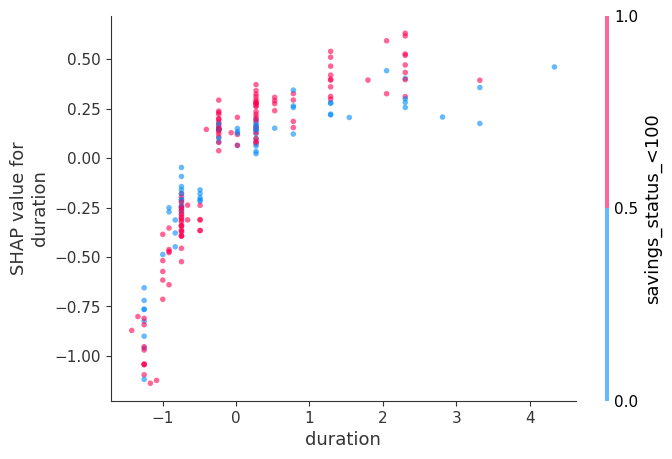

<Figure size 800x500 with 0 Axes>

In [14]:
top_features = feat_imp['feature'].head(2).tolist()
print("Top 2 features for dependence:", top_features)

for feature in top_features:
    # shap.dependence_plot expects the original (transformed) matrix and shap values, and feature index or name
    try:
        shap.dependence_plot(feature, shap_values, X_test_transformed, feature_names=feature_names, interaction_index='auto', alpha=0.6)
    except Exception as e:
        print("Dependence plot error for", feature, ":", e)
    plt.tight_layout()
    plt.show()


In [15]:
# Save the trained pipeline and results
joblib.dump(best_model, "xgb_credit_pipeline.joblib")
np.save("shap_values_test.npy", shap_values)
pd.DataFrame(feat_imp).to_csv("feature_importance_shap.csv", index=False)
print("Saved model and artifacts.")


Saved model and artifacts.
